In [439]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sys, time
from IPython.display import clear_output, display

# Numerical resolution of KdV equation using a Finite Volume method

## Model : Korteweg - de Vries (KdV) equation :

We will compute an approximate solution to the KdV equation, which models a wave propagation accpounting for nonlinear ansd dispersive effects : 

\begin{equation}
\begin{cases}
    u_t + u_x + (u^2)_x + u_{xxx} = 0 \ , \ \ x \in [x_{min},x_{max}], \ \ t \in [0, t_{max}] \\
    u(x,0) = \Phi(x)
\end{cases}
\end{equation}

The kdV equation will be split in two equations, leading to the resolution of the following problem in each time step: 

\begin{equation}
\begin{cases}
    v_t + v_x + (v^2)_x = 0 \ \ ,\ t \in [t_n,t_{n+1}], \  v(t_n) = u(t_n) \\
    w_t + w_{xxx} = 0 \ \ , \ t \in [t_n,t_{n+1}], \  w(t_n) = v(t_{n+1}) \\
    u(t_{n+1}) = v(t_{n+1})
\end{cases}
\end{equation}

## First equation
$ v_t + f(v)_x = 0, \ \ f(v) = v + v^2 $


### Temporal discretization

#### Euler
$v_i^{n+1} = v_i^n - \Delta t  \  f(v_i^n)_x$

#### 4th order Runge-Kutta
\begin{equation}
\begin{cases}
k_1 = - f(v_i^n)_x \\
k_2 = - f\left(v_i^n + k_1\frac{\Delta t }{2}\right)_x \\
k_3 = - f\left(v_i^n + k_2\frac{\Delta t }{2}\right)_x \\
k_4 = - f(v_i^n + k_3 \Delta t)_x \\
v_i^{n+1} = v_i^n + \frac{\Delta t}{6}(k_1 + 2k_2 + 2k_3 + k_4)
\end{cases}
\end{equation}



### Spatial discretization
$ f(v_i^n)_x = \frac{f\left(v_{i+1/2}^n\right) - f\left(v_{i-1/2}^n\right)}{\Delta x}$


### Choice of the steps
In the non-conservative form, the equation is written as

$v_t +  (1+2v)v_x = 0$

which configures an advection problem with velocity $1+2v$

The space and time steps must verify the CFL condition : 

$(1+2v)\frac{\Delta t}{\Delta x} \leq 1$

in order to avoid non-physical behaviours (e.g. mass increasing). Thereforem for each time step, we will chose, for small $\epsilon$

$\Delta t = \frac{\Delta x}{1+2\max\limits_{x}|v|} - \epsilon$





### Evaluation of the solution on cell interfaces : resolution of the Riemann problem
In each interface between two cells of the discrete domain, the follozing Riemann problem will be solved :

\begin{equation}
\begin{cases}
v_t + f(v)_x = 0 \\
v(x,0) = v^- \ , \ x < 0 \\
v(x,0) = v^+ \ , \ x > 0
\end{cases}
\end{equation}

where the boundary is located at $x=0$ and $v^-$ and $v^+$ are the solutions in its two neighbour cells.

The flux function $f$ is uniformly convex, so the Riemann problem has a unique weak, admissible solution (REFERENCE) :

* If $v^- > v^+$  (shock) : 
\begin{equation}
v(x,t) = 
\begin{cases}
v^- \ ,\ \   f(v^-) > f(v^+) \\
v^+ \ ,\ \ f(v^-) < f(v^+)
\end{cases}
\end{equation}

* If $v^+ > v^-$  (rarefaction wave) :
\begin{equation}
v(x,t) = 
\begin{cases}
v^- \ ,\ \ f'(v^-) > 0 \\
\left(f'\right)^{-1}(v) \ ,\ \ f'(v^-) < 0 < f'(v^+) \\
v^+ \ ,\ \ f'(v^+) < 0 
\end{cases}
\end{equation}

## Second equation

The second equation will be solved using the Fourier method. Let $\hat{w}(k,t_n)$ be the Fourier coefficients of $w(x,t_n)$.  The Fourier transform of the equation

$w_t+w_{xxx}=0$

gives

$(\hat{w})_t(k,t) - ik^3\hat{w}(k,t)$ = 0

It is an ODE which solution is
$\hat{w}(k,t) = e^{ik^3(t-t_n)}\hat{u}(k,t_n)$

The inverse Fourier transform using the coefficients $\hat{w}(k,t_{n+1})$ gives $w(x,t_{n+1})$

In [440]:
### Spatial discretization
xlower = 0
xupper = 2
dx = 0.025
nx = int((xupper-xlower)/dx)
x = np.linspace(xlower, xupper,nx+1)

In [441]:
### Initial solution
u = np.zeros(x.shape) # On the cells
uint = np.zeros(x.shape) # On the interfaces

## Square wave
for i in range(int(3*nx/10), int(4*nx/10)):
    u[i] = 1.
    
## Gaussian wave
#u = np.exp(-np.power(x-xupper/2.,2))   

#u = np.cos(x*np.pi)

#u = 2/np.power(np.cosh(x),2)

uleft = u[0]
uright = u[nx]

umax = np.amax(np.absolute(u))

In [442]:
### Time discretization
t0 = 0
tmax = 3

In [443]:
def Flux(u):
    return u + u*u
def Fluxder(u):
    return 1. + 2.*u
def Fluxderinv(u):
    return (u-1.)/2.

In [444]:
def Riemann(u,x,t):
    for  i in range(1,x.size-1):
        #incl = x[i]/t
        incl = 0
        um = u[i]
        up = u[i+1]
        if um == up :
            uint[i] = um
        elif  um > up:
            sigma = (Flux(um) - Flux(up))/(um-up)
            if incl < sigma:
                uint[i] = um
            else:
                uint[i] = up
        else:
            if incl < Fluxder(um) :
                uint[i] = um
            elif incl > Fluxder(up) :
                uint[i] = up
            else:
                uint[i] = Fluxderinv(incl)
    uint[0] = u[0]
    uint[x.size-1] = u[x.size-1]
    return uint

In [445]:
def Euler(u,dx,dt):
    umm = np.roll(u,1)
    f = Flux(u)
    fmm = Flux(umm)
    
    u2 = u - dt/dx*(f-fmm)
    
    return u2

In [446]:
def RK4(u,dx,dt):
    umm = np.roll(u,1)
    
    f = Flux(u)
    fmm = Flux(umm)
    k1 = dt*(fmm-f)/dx
    
    f = Flux(u+k1/2.)
    fmm = Flux(umm+k1/2.)
    k2 = dt*(fmm-f)/dx
 
    f = Flux(u+k2/2.)
    fmm = Flux(umm+k2/2.)
    k3 = dt*(fmm-f)/dx
    
    f = Flux(u+k3)
    fmm = Flux(umm+k3)
    k4 = dt*(fmm-f)/dx
    
    u2 = u + 1./6.*(k1+2*k2+2*k3+k4)
    
    return u2

In [447]:
def FourierSolver(u,t,dt):
    uhat = np.fft.fft(u)
    uhat = uhat*np.exp(dt*1.j*np.power(np.fft.fftfreq(uhat.size),3))
    u2 = np.fft.ifft(uhat)
#    if not (np.all(np.isreal(u2))):
#        print(u2)
#        sys.exit("Error in Fourier method")
    return np.real(u2)

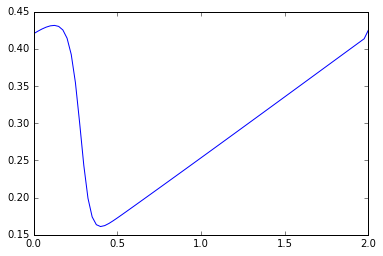

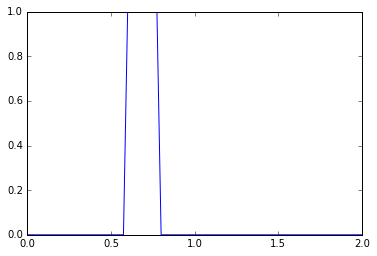

In [448]:
t = t0
u0 = u
printstep = 5
iter = 0
eps = 1e-6
plt.plot(x,u)
graph, axes = plt.subplots()
periodic = 1
while t<tmax:
    iter = iter + 1
    dt = dx/(1.+2*umax) - eps     # CFL CONDITION (???)
    #dt = dx
    t = t+dt
    uint = Riemann(u,x,t)
    u= RK4(uint,dx,dt)  
    #u = Euler(uint,dx,dt)
    if periodic:
        aux = u[0]
        u[0] = u[nx]
        u[nx] = aux
    else:
        u[0] = uleft ## Boundary conditions ?
        u[nx] = uright        
    u2 = u
    u = FourierSolver(u,t,dt)
    if iter%printstep == 0:
        #plt.ylim((-1,1))
        axes.plot(x,u)
        #time.sleep(.01)
        clear_output(True)
        display(graph)
        axes.cla()
    #if iter%printstep == 0:
    #    plt.plot(x,u)
plt.close()

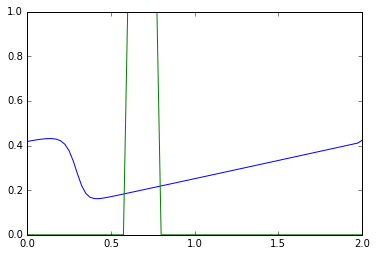

In [449]:
plt.plot(x,u)
plt.plot(x,u0)